### Set up the panel for data to be merged in

In [51]:
clear
cd 
// There are 13213 signal intersections
global intersect = 13213+1
global obs = 12*7*($intersect)

display $obs





1109976

D:\Box Sync\Policy Evaluation\dofiles


In [52]:
set obs $obs

egen intersection_id = seq(), from(1) to($intersect)
sort intersection_id

egen month = seq(), from(1) to (12) by(intersection_id)
egen year = seq(), from(2012) to (2018) block(12) 

gen monthly = ym(year, month)
format monthly %tm

//These are outside of the range of our data
drop if month < 7 & year == 2012
drop if month > 9 & year == 2018


number of observations (_N) was 0, now 1,109,976







(79,284 observations deleted)

(39,642 observations deleted)


### Merge in Intersection data from "Signal intersection.ipynb"


In [53]:
mmerge intersection_id using "..\working_data\signal_intersection.dta", ///
type(n:1) ///
unmatched(using) ///
umatch(intersection_id)



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | using
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 991050
                vars |      4
          match vars | intersection_id  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\signal_intersection.dta
                 obs |  13209
                vars |     42
          match vars | intersection_id  (key)
---------------------+---------------------------------------------------------
variable intersection_id does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 990675
                vars |     47  (including _merge)
         ------------+----

In [65]:
describe


Contains data
  obs:       990,675                          
 vars:            52                          
 size:   482,458,725                          
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
intersection_id int     %8.0g                 
month           byte    %8.0g                 
year            int     %8.0g                 
monthly         int     %tm                   
index           int     %12.0g            

### Create borough dummies


In [55]:
// Create borough dummies
tab bname,m
gen bronx = (bname == "Bronx")
gen brooklyn = (bname == "Brooklyn")
gen manhattan = (bname == "Manhattan")
gen queens = (bname == "Queens")
gen statenisland = (bname == "Staten Island")



        bname |      Freq.     Percent        Cum.
--------------+-----------------------------------
        Bronx |    127,800       12.90       12.90
     Brooklyn |    352,200       35.55       48.45
    Manhattan |    215,325       21.74       70.19
       Queens |    248,400       25.07       95.26
Staten Island |     46,950        4.74      100.00
--------------+-----------------------------------
        Total |    990,675      100.00







### Lion Street data 

In [57]:
// Lion Street data 
// Variables: Number_Tra Number_Par Number_Tot TrafDir distance_to_Street nearest_Street
rename Number_Tra No_traveling_lanes
rename Number_Par No_parking_lanes
rename Number_Tot No_total_lanes
rename TrafDir trafdir

In [60]:
replace No_traveling_lanes = "" if No_traveling_lanes == "None"
replace No_parking_lanes = "" if No_parking_lanes == "None"
replace No_total_lanes = "" if No_total_lanes == "None"
destring No_traveling_lanes No_parking_lanes No_total_lanes, replace


(120,675 real changes made)

(238,500 real changes made)

(120,750 real changes made)

No_traveling_lanes: all characters numeric; replaced as byte
(120675 missing values generated)
No_parking_lanes: all characters numeric; replaced as byte
(238500 missing values generated)
No_total_lanes: all characters numeric; replaced as byte
(120750 missing values generated)


In [61]:
replace trafdir = "1" if trafdir == "W"
replace trafdir = "2" if trafdir == "A"
replace trafdir = "3" if trafdir == "T"
replace trafdir = "4" if trafdir == "P"
replace trafdir = "" if trafdir == "None"
destring trafdir, replace

label define trafdir1 1 "With: One-way street, traffic flows with the segment's directionality" ///
2 "Against: One-way street, traffic flows from against the segment's directionality" ///
3 "Two-Way: Traffic flows in both directions" ///
4 "Pedestrian path: Non-vehicular"
label values trafdir trafdir1


(208,350 real changes made)

(198,975 real changes made)

(515,250 real changes made)

(5,925 real changes made)

(62,175 real changes made)

trafdir: all characters numeric; replaced as byte
(62175 missing values generated)




### Nearest Bike Route data

In [ ]:
// Nearest Bike Route data
// Variables date_instd tf_facilit nearest_bikeroute distance_to_bikeroute

In [64]:
tab date_instd

variable date_instd not found


r(111);


In [62]:
destring nearest_bikeroute, replace

gen bike_route_install_dt = date(date_instd, "YMD"), after(date_instd)
format bike_route_install_dt %td
gen bike_route_install_mt = mofd(bike_route_install_dt)
format bike_route_install_mt %tm

// drop date_instd



nearest_bikeroute already numeric; no replace

(990,675 missing values generated)


(990,675 missing values generated)




In [6]:
codebook nearest_Street


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
nearest_Street                                                                                                                                                                                                                                      (unlabeled)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  numeric (long)

                 range:  [3,222595]                   units:  1
         unique values:  13,091                   missing .:  525/995,775

                  mean:   89486.9
              st

In [7]:
//Need to find out why the nearest neighbor did not work to assign these ids with the street ids
tab intersection_id if mi(nearest_Street)


intersectio |
       n_id |      Freq.     Percent        Cum.
------------+-----------------------------------
       2806 |         75       14.29       14.29
       2807 |         75       14.29       28.57
       4580 |         75       14.29       42.86
       4600 |         75       14.29       57.14
       9303 |         75       14.29       71.43
      13246 |         75       14.29       85.71
      13248 |         75       14.29      100.00
------------+-----------------------------------
      Total |        525      100.00


In [8]:
tab geometry if mi(nearest_Street)


                               geometry |      Freq.     Percent        Cum.
----------------------------------------+-----------------------------------
POINT (-1.797693134862316e+308 -1.797.. |        525      100.00      100.00
----------------------------------------+-----------------------------------
                                  Total |        525      100.00


In [9]:
tab ST1_Name ST2_Name if mi(nearest_Street)


                      |                             ST2_Name
             ST1_Name |  150 ST E   CANAL ST  MAJOR D..  OSBORN ST    WAVE ST  WOF 7 AVE |     Total
----------------------+------------------------------------------------------------------+----------
             153 ST E |         0          0         75          0          0          0 |        75 
              31 ST W |         0          0          0          0          0         75 |        75 
              33 ST W |         0          0          0          0          0         75 |        75 
          EXTERIOR ST |        75          0          0          0          0          0 |        75 
             FRONT ST |         0         75          0          0         75          0 |       150 
          HEGEMAN AVE |         0          0          0         75          0          0 |        75 
----------------------+------------------------------------------------------------------+----------
                Total |

In [10]:
// For the time being drop these that do not have street information
drop if _merge == -1
drop _merge

replace trafdir = "1" if trafdir == "W"
replace trafdir = "2" if trafdir == "A"
replace trafdir = "3" if trafdir == "T"
replace trafdir = "4" if trafdir == "P"
destring trafdir, replace
label define trafdir1 1 "With: One-way street, traffic flows with the segment's directionality" ///
2 "Against: One-way street, traffic flows from against the segment's directionality" ///
3 "Two-Way: Traffic flows in both directions" ///
4 "Pedestrian path: Non-vehicular"
label values trafdir trafdir1


(525 observations deleted)


(209,250 real changes made)

(199,725 real changes made)

(517,800 real changes made)

(5,925 real changes made)

trafdir: all characters numeric; replaced as byte
(62550 missing values generated)




In [11]:
destring nearest_bikeroute, replace

nearest_bikeroute: all characters numeric; replaced as long


In [13]:
// Merging in Nearest Bike Route data
mmerge nearest_bikeroute using "..\working_data\bike_routes_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(objectid_1) ///
ukeep(date_instd date_modda onoffst lanecount)





-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 995250
                vars |     30
          match vars | nearest_bikeroute  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\bike_routes_2263.dta
                 obs |  14980
                vars |      5  (selection via udrop/ukeep)
          match vars | objectid_1  (key)
---------------------+---------------------------------------------------------
variable nearest_bikeroute does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 995250
                vars |     36  (including _merge)


In [14]:
tab date_instd


 date_instd |      Freq.     Percent        Cum.
------------+-----------------------------------
 1920-01-01 |        675        3.11        3.11
 1936-01-01 |        150        0.69        3.81
 1941-01-01 |      2,100        9.69       13.49
 1970-01-01 |        600        2.77       16.26
 1979-01-01 |        150        0.69       16.96
 1979-05-01 |      3,375       15.57       32.53
 1979-07-01 |        150        0.69       33.22
 1980-07-01 |        150        0.69       33.91
 1987-01-01 |         75        0.35       34.26
 1996-01-01 |        300        1.38       35.64
 1996-04-01 |         75        0.35       35.99
 1997-04-01 |        150        0.69       36.68
 1998-01-01 |         75        0.35       37.02
 1998-07-01 |        225        1.04       38.06
 1999-07-01 |         75        0.35       38.41
 2001-11-01 |        750        3.46       41.87
 2003-06-01 |         75        0.35       42.21
 2003-11-01 |        150        0.69       42.91
 2004-01-01 |      

In [15]:
gen bike_route_install_dt = date(date_instd, "YMD"), after(date_instd)
format bike_route_install_dt %td
gen bike_route_install_mt = mofd(bike_route_install_dt)
format bike_route_install_mt %tm

gen bike_route_modif_dt = date(date_modda, "YMD"), after(date_modda)
format bike_route_modif_dt %td
gen bike_route_modif_mt = mofd(bike_route_modif_dt)
format bike_route_modif_mt %tm


(973,575 missing values generated)


(973,575 missing values generated)


(973,575 missing values generated)


(973,575 missing values generated)



In [16]:
sum bike_route_modif_mt, format


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
bike_ro~f_mt |     21,675   2001m10    276.9386   1936m1  2016m12


In [17]:
drop date_instd
drop date_modda

In [18]:
destring nearest_truckroute, replace

nearest_truckroute already numeric; no replace


In [19]:
// Merging in Truck Route data
mmerge nearest_truckroute using "..\working_data\All_truck_routes_nyc_lion14A.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(objectid) ///
ukeep(bikelane routetype)

label define bikelane1 1 "Class 1: Separated Greenway" ///
2 "Class II: Striped Bike Lane" ///
3 "Class III: Signed Bicycle Route" ///
4 "Links: Connecting segments." ///
5 "Class I, II: Combination of Class I and II" ///
6 "Class II, III: Combination of Class II and III" ///
7 "Stairs: Includes step streets, bridge stairs, etc."
label values bikelane bikelane1
rename bikelane bikelane_type



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 995250
                vars |     36
          match vars | nearest_truckroute  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\All_truck_routes_nyc_lion14A.dta
                 obs |  31641
                vars |      3  (selection via udrop/ukeep)
          match vars | objectid  (key)
---------------------+---------------------------------------------------------
variable nearest_truckroute does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 995250
                vars |     40  (includ

In [55]:
// Merging in Left turn calming interventions information
mmerge nearest_LTC using "..\working_data\VZV_Left_Turn_Traffic_Calming_shapefile_2263.dta" , ///
type(n:1) ///
unmatched(master) ///
umatch(id) ///
ukeep( date_compl treatment_)

rename treatment_ left_turn_treatment

gen left_turn_install_dt = date(date_compl, "YMD"), after(date_compl)
format left_turn_install_dt %td
drop date_compl
gen int left_turn_install_month = mofd(left_turn_install_dt), after(left_turn_install_dt)
format left_turn_install_month %tm



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 995250
                vars |     38
          match vars | nearest_LTC  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\working_data\VZV_Left_Turn_Traffic_Calming_shapefile_2263.dta
                 obs |    217
                vars |      3  (selection via udrop/ukeep)
          match vars | id  (key)
---------------------+---------------------------------------------------------
variable nearest_LTC does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 995250
                vars |     42  (including 

In [20]:
// Matching intersection to closest Left turn calming interventions
egen double left_turn_min = min(intersection_to_left_turn_dist), by(left_turn_id)
gen flag_left_turn_ever = .
replace flag_left_turn_ever = 1 if left_turn_min == intersection_to_left_turn_dist
replace flag_left_turn_ever = 0 if mi(flag_left_turn_ever)

gen flag_left_turn = flag_left_turn_ever
replace flag_left_turn = 0 if flag_left_turn == 1 & monthly < left_turn_install_month


intersection_to_left_turn_dist not found


r(111);
r(111);


In [13]:
// Merging Street Improv Project interventions
mmerge intersection_id using "..\input_data\intersection_street_improv_proj_shapefile_2263\intersection_street_improv_proj_shapefile_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(fid) ///
ukeep(HubName HubDist)

rename HubName street_improv_id
rename HubDist intersec_to_street_improv_dist

// Merging in Street Improv Project interventions information
mmerge street_improv_id using "..\working_data\VZV_street_improve_proj_shapefile_2263.dta" , ///
type(n:1) ///
unmatched(master) ///
umatch(id) ///
ukeep(sipproj_ty date_date )

rename sipproj_ty street_improv_treatment

gen street_improv_install_dt = date(date_date, "YMD"), after(date_date)
format street_improv_install_dt %td
drop date_date
gen int street_improv_install_month = mofd(street_improv_install_dt), after(street_improv_install_dt)
format street_improv_install_month %tm



-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 3836175
                vars |     49
          match vars | intersection_id  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\input_data\intersection_street_improv_proj_shapefile_2263\intersection_street_improv_proj_shapefile_2263.dta
                 obs |  51149
                vars |      3  (selection via udrop/ukeep)
          match vars | fid  (key)
---------------------+---------------------------------------------------------
variable intersection_id does not uniquely identify observations in the master data
result          file | <data in memory not named>
               

In [14]:
// Matching intersection to closest street improvment interventions
egen double street_improv_min = min(intersec_to_street_improv_dist), by(street_improv_id)
gen flag_street_improv_ever = .
replace flag_street_improv_ever = 1 if street_improv_min == intersec_to_street_improv_dist
replace flag_street_improv_ever = 0 if mi(flag_street_improv_ever)

gen flag_street_improv = flag_street_improv_ever
replace flag_street_improv = 0 if flag_street_improv == 1 & monthly < street_improv_install_month



(3,836,175 missing values generated)

(13,125 real changes made)

(3,823,050 real changes made)


(5,691 real changes made)


In [15]:
// Merging in LPIS information
mmerge intersection_id using "..\input_data\intersection_to_LPIS_2263\intersection_to_LPIS_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(fid) ///
ukeep(HubName HubDist)

drop _merge
rename HubName LPIS_id
rename HubDist intersection_to_LPIS_dist
label variable LPIS_id "ID of nearest LPIS"
label variable intersection_to_LPIS_dist "Dist. of nearest LPIS to intersection"

// Merging in LPIS information
mmerge LPIS_id using "..\working_data\leading_pedestrian_interval_signals_shapefile_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(id) ///
ukeep(install_da) 

drop _merge
gen LPIS_install_date = date(install_da, "YMD")
format LPIS_install_date %td
drop install_da
gen int LPIS_install_month = mofd(LPIS_install_date), after(LPIS_install_date)
format LPIS_install_month %tm
gen LPIS_install_year = year(LPIS_install_date)




-------------------------------------------------------------------------------
merge specs          |
       matching type | n:1
  mv's on match vars | none
  unmatched obs from | master
---------------------+---------------------------------------------------------
  master        file | <data in memory not named>
                 obs | 3836175
                vars |     57
          match vars | intersection_id  (not a key)
  -------------------+---------------------------------------------------------
  using         file | ..\input_data\intersection_to_LPIS_2263\intersection_to_LPIS_2263.dta
                 obs |  51149
                vars |      3  (selection via udrop/ukeep)
          match vars | fid  (key)
---------------------+---------------------------------------------------------
variable intersection_id does not uniquely identify observations in the master data
result          file | <data in memory not named>
                 obs | 3836175
                vars |    

In [16]:
// Matching intersection to closest LPIS intersection
egen double LPIS_min = min(intersection_to_LPIS_dist), by(LPIS_id)
gen flag_LPIS_ever = .
replace flag_LPIS_ever = 1 if LPIS_min == intersection_to_LPIS_dist
replace flag_LPIS_ever = 0 if mi(flag_LPIS_ever)

gen flag_LPIS = flag_LPIS_ever



(3,836,175 missing values generated)

(176,925 real changes made)

(3,659,250 real changes made)



In [17]:
// Problem1: Missing Install date on some LPIS IDs
sum LPIS_install_month, detail format
codebook LPIS_install_month 
tab LPIS_id if mi(LPIS_install_month) & flag_LPIS == 1
tab intersection_id if mi(LPIS_install_month) & flag_LPIS == 1
sum intersection_to_LPIS_dist if mi(LPIS_install_month)

// Solution1: Drop these intersections
tab flag_LPIS if mi(LPIS_install_month)
drop if mi(LPIS_install_month) & flag_LPIS == 1
*1,725 observations deleted
replace flag_LPIS = 0 if flag_LPIS == 1 & monthly < LPIS_install_month


// Problem2: Certain LPIS junctions have been installed 
// before the collisions datasets begin
// Removing junctions that cannot be analyzed because LPIS was done before 01jul2012
sum monthly, detail format
sum LPIS_install_month, detail format
// Solution2: Drop these observations 
tab flag_LPIS if LPIS_install_month < tm(2013m1)
tab intersection_id if LPIS_install_month < tm(2013m1) & flag_LPIS_ever == 1
drop if LPIS_install_month < tm(2013m1) & flag_LPIS_ever == 1
* 15,750 observations deleted
duplicates tag intersection_id, gen(dup)
tab dup
drop dup

label variable flag_LPIS "Indicates the intersection at the time they became an LPIS intervention"
label variable flag_LPIS_ever "Indicates the intersection if they ever received LPIS intervention"




                     LPIS_install_month
-------------------------------------------------------------
      Percentiles      Smallest
 1%     1995m5       1978m6
 5%     2004m4       1978m6
10%     2013m6       1978m6       Obs           3,815,025
25%     2015m9       1978m6       Sum of Wgt.   3,815,025

50%     2016m5                      Mean           2015m4
                        Largest       Std. Dev.        54.626
75%     2017m3       2018m1
90%    2017m10       2018m1       Variance           2984
95%    2017m12       2018m1       Skewness      -4.129717
99%     2018m1       2018m1       Kurtosis       22.91646


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
LPIS_install_month                                                                                             

      37135 |         75        0.48       14.76
      37690 |         75        0.48       15.24
      38557 |         75        0.48       15.71
      38768 |         75        0.48       16.19
      39849 |         75        0.48       16.67
      40649 |         75        0.48       17.14
      40652 |         75        0.48       17.62
      40666 |         75        0.48       18.10
      43266 |         75        0.48       18.57
      45846 |         75        0.48       19.05
      47048 |         75        0.48       19.52
      50013 |         75        0.48       20.00
      52088 |         75        0.48       20.48
      54180 |         75        0.48       20.95
      54202 |         75        0.48       21.43
      54203 |         75        0.48       21.90
      54204 |         75        0.48       22.38
      54205 |         75        0.48       22.86
      54206 |         75        0.48       23.33
      54207 |         75        0.48       23.81
      54460 |       

     147224 |         75        0.48       94.76
     147293 |         75        0.48       95.24
     147302 |         75        0.48       95.71
     147381 |         75        0.48       96.19
     147388 |         75        0.48       96.67
     147697 |         75        0.48       97.14
     147827 |         75        0.48       97.62
     148609 |         75        0.48       98.10
     149404 |         75        0.48       98.57
     149845 |         75        0.48       99.05
     152798 |         75        0.48       99.52
     152800 |         75        0.48      100.00
------------+-----------------------------------
      Total |     15,750      100.00

(15,750 observations deleted)


Duplicates in terms of intersection_id


        dup |      Freq.     Percent        Cum.
------------+-----------------------------------
         74 |  3,818,700      100.00      100.00
------------+-----------------------------------
      Total |  3,818,700      100.00






(bin=65, start=.00104, width=235.92449)


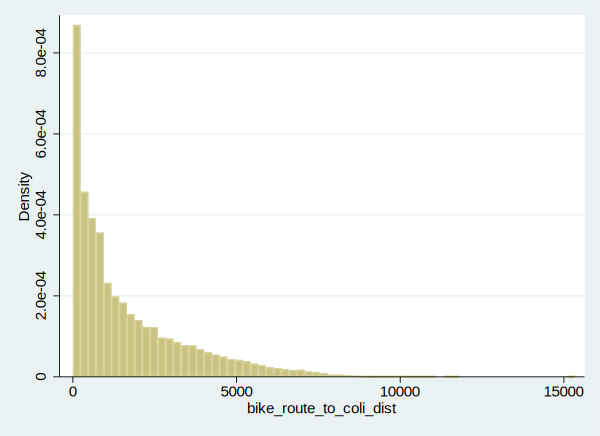







                   bike_route_to_coli_dist
-------------------------------------------------------------
      Percentiles      Smallest
 1%       .05614         .00104
 5%        .1418         .00104
10%       .27621         .00104       Obs           3,818,700
25%     294.5067         .00104       Sum of Wgt.   3,818,700

50%     987.8419                      Mean           1660.238
                        Largest       Std. Dev.      1788.305
75%     2494.563       15335.09
90%     4347.356       15335.09       Variance        3198036
95%     5461.802       15335.09       Skewness       1.416199
99%     7352.794       15335.09       Kurtosis       4.655048


                   bike_route_to_coli_dist
-------------------------------------------------------------
      Percentiles      Smallest
 1%        .0266         .00104
 5%       .06345         .00104
10%       .09357         .00104       Obs             954,675
25%       .16444         .00104       Sum of Wgt.     954,675

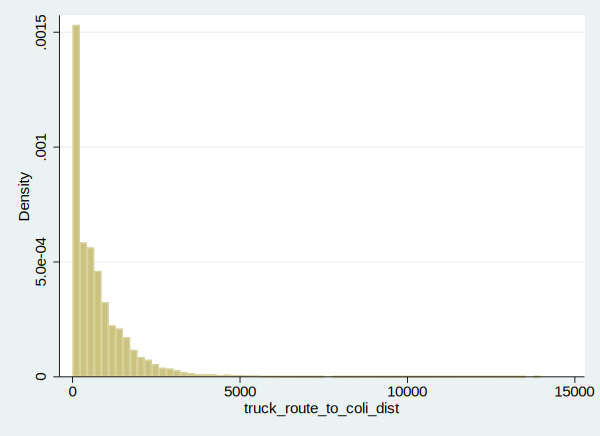







                  truck_route_to_coli_dist
-------------------------------------------------------------
      Percentiles      Smallest
 1%       .04811         .00273
 5%       .11801         .00273
10%         .185         .00273       Obs           3,818,700
25%     30.98866         .00273       Sum of Wgt.   3,818,700

50%     514.5632                      Mean           807.2051
                        Largest       Std. Dev.      1124.024
75%     1092.665       13971.74
90%     1930.511       13971.74       Variance        1263430
95%      2641.56       13971.74       Skewness       4.071354
99%     5013.904       13971.74       Kurtosis       31.47821


                  truck_route_to_coli_dist
-------------------------------------------------------------
      Percentiles      Smallest
 1%        .0337         .00273
 5%       .08105         .00273
10%       .11801         .00273       Obs           1,909,350
25%       .23308         .00273       Sum of Wgt.   1,909,350

In [18]:
// Determine if collision is on bike route
histogram bike_route_to_coli_dist
graph close
sum bike_route_to_coli_dist, detail
sum bike_route_to_coli_dist if bike_route_to_coli_dist < r(p25) , detail
gen bike_route_ever = bike_route_to_coli_dist < 2
tab bike_route_ever

label variable bike_route_ever "Indicates that bike route passes through this intersection (<2 ft)"


// Timevarient bike route indicator
gen bike_route_tv = 0 
replace bike_route_tv = 1 if monthly >= bike_route_install_mt & bike_route_ever == 1

label variable bike_route_tv "Indicates that bike route passes through this intersection timevarient(<2 ft)"

// Determine if collision is on truck route
histogram truck_route_to_coli_dist
graph close
sum truck_route_to_coli_dist, detail
sum truck_route_to_coli_dist if truck_route_to_coli_dist < r(p50) , detail
sum truck_route_to_coli_dist if truck_route_to_coli_dist < r(p90) , detail
gen truck_route = truck_route_to_coli_dist < 3
tab truck_route

label variable truck_route "Indicates that truck route passes through this intersection (<3 ft)"


In [19]:
// Problem 3: Missing intersection data
// Solution 3: Inpute it as mean
codebook number_travel_lanes
gen mi_number_travel_lanes = mi(number_travel_lanes), after(number_travel_lanes)
sum number_travel_lanes
replace number_travel_lanes = r(mean) if mi_number_travel_lanes == 1

codebook number_park_lanes
gen mi_number_park_lanes = mi(number_park_lanes), after(number_park_lanes)
sum number_park_lanes
replace number_park_lanes = 0 if mi_number_park_lanes == 1

// Merge in Signal information
mmerge intersection_id using "..\input_data\intersection_to_signal_2263\intersection_to_signal_2263.dta", ///
type(n:1) ///
unmatched(master) ///
umatch(fid) ///
ukeep(HubDist) 

gen int inters_to_sig_dist = round(HubDist, 0.01)
drop HubDist



---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
number_travel_lanes                                                                                                                                                                                                                                 (unlabeled)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

                  type:  numeric (byte)

                 range:  [1,16]                       units:  1
         unique values:  9                        missing .:  455,850/3,818,700

            tabulation:  Freq.  Value
     


(bin=65, start=0, width=272.64615)


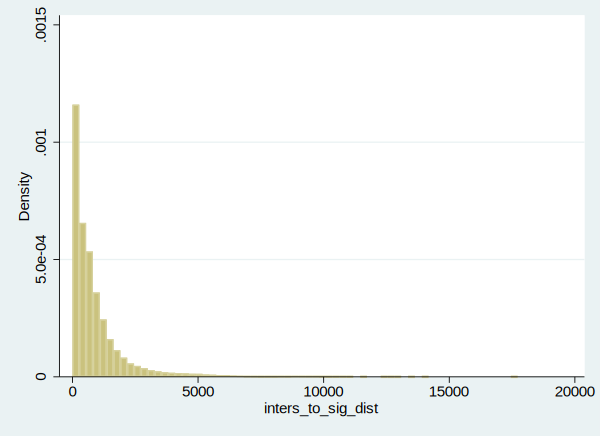







                     inters_to_sig_dist
-------------------------------------------------------------
      Percentiles      Smallest
 1%            0              0
 5%            0              0
10%            1              0       Obs           3,818,700
25%          232              0       Sum of Wgt.   3,818,700

50%          553                      Mean           930.6361
                        Largest       Std. Dev.      1271.663
75%         1130          17722
90%         2151          17722       Variance        1617126
95%         3328          17722       Skewness       3.343016
99%         6292          17722       Kurtosis        18.7371


(45,675 real changes made)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
intersection_id                           

In [20]:
// Determine if intersection is on signalized traffic
histogram inters_to_sig_dist
graph close
sum inters_to_sig_dist, detail

gen signalized_intersection = (inters_to_sig_dist < 100) // 1 city block width is about 270ft
replace signalized_intersection = 1 if flag_LPIS_ever == 1
codebook intersection_id if signalized_intersection == 1
